In [1]:
from __future__ import division
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline

import pyfits as fits
from scipy.stats import norm

In [2]:
import matplotlib.animation as animation
#%pylab inline

In [3]:
docompute = True

In [4]:
import os

In [5]:
root_path = './../'

In [6]:
#filename = "muse_scipost_N_ASASSN14lp_1_new_DATACUBE_FINAL_IFU_004_zap_all.fits"
filename = "muse_scipost_N_SN2009bb_DATACUBE_FINAL_IFU_001_zap.fits"
#filename = "muse_scipost_N_SN2004ef_DATACUBE_FINAL_IFU_002_skysub.fits"
data = fits.open(root_path+filename)
_image = data[1].data
header = data[1].header
del data

In [7]:
image = _image[:, 100:300, 20:220]

In [8]:
#image = image[:, 63:263, 100:300]
#image = _image[:, 100:300, 20:220]
(nl, nx, ny) = np.shape(image)
image2D = np.sum(image, axis = 0)
image2D[np.invert(np.isfinite(image2D))] = 0
image2D = np.arcsinh(image2D)
fig, ax = plt.subplots(figsize = (10, 10))
l1, l2 = (np.percentile(image2D.flatten(), 1), np.percentile(image2D.flatten(), 99))
print(l1, l2)
color = ax.imshow(image2D, clim = (10, 14));
fig.colorbar(color)

10.8111085796 15.0137771416


In [9]:
# spectral wavelengths
CRVAL3 = float(header["CRVAL3"])
CRPIX3 = float(header["CRPIX3"])
CUNIT3 = header["CUNIT3"]
CD31 = float(header["CD3_1"])
CD32 = float(header["CD3_2"])
CD33 = float(header["CD3_3"])
NAXIS3 = int(header["NAXIS3"])
lambdas = np.array(CRVAL3 + CD33 * (np.arange(NAXIS3) - CRPIX3))

**Asumimos que $H\alpha$ es la más intensa.**

In [10]:
H_alpha = 6562.8
spectra = _image[:, 120, 50]

In [11]:
fig, ax = plt.subplots(figsize = (20, 5))
ax.plot(lambdas, spectra)
ax.set_xlim(min(lambdas), max(lambdas))
plt.ylabel('intensity')
plt.xlabel('wave-lenghts')
plt.plot([H_alpha,H_alpha],[spectra.min(),spectra.max()], c='red')

In [12]:
_max = lambdas[spectra.argmax()]
_max

6628.47607421875

In [13]:
z_1 = _max/H_alpha

In [14]:
lambdas_shiftted = lambdas/z_1

In [15]:
fig, ax = plt.subplots(figsize = (20, 5))
spectra = image[:, 120, 50]
ax.plot(lambdas_shiftted, spectra)
ax.set_xlim(min(lambdas), max(lambdas))
plt.ylabel('intensity')
plt.xlabel('wave-lenghts')
plt.plot([H_alpha,H_alpha],[spectra.min(),spectra.max()], c='red')

### Shift of the full data set.

In [16]:
all_maximums = image.argmax(0)
all_maximums.shape

(200, 200)

In [17]:
all_lambdas = lambdas[all_maximums]
print(all_lambdas.shape)

all_z_1 = all_lambdas/H_alpha
print(all_z_1.shape)

(200, 200)
(200, 200)


In [18]:
multiply_lambdas = np.repeat(np.matrix(lambdas), all_z_1.shape[0], axis=0)  #(3681,) to (3681,321,320)

In [19]:
multiply_lambdas.T.shape

(3681, 200)

In [20]:
transformed = np.array([multiply_lambdas for i in range(all_z_1.shape[1])]).T

In [21]:
transformed.shape

(3681, 200, 200)

### Amplify image.

In [111]:
lambdas_to_check = np.array([all_maximums-i for i in range(1,10)]+[all_maximums]+[all_maximums+i for i in range(1,10)])

In [112]:
lambdas_to_check.max()

3689

In [113]:
lambdas_to_check.shape

(19, 200, 200)

In [114]:
noise = np.zeros((image.shape[1],image.shape[2]))
noise.shape

(200, 200)

In [115]:
for i in range(image.shape[1]):
    for j in range(image.shape[2]):
        try:
            _s_lambdas = lambdas_to_check[:,i,j]
            #print(_s_lambdas, image[_s_lambdas,i,j].shape)
            _mean = image[_s_lambdas,i,j].mean()
            _std = image[_s_lambdas,i,j].std()
            _Halpha = _s_lambdas[_s_lambdas.shape[0]//2+_s_lambdas.shape[0]%2]
            if _Halpha > _mean+2*_std:
                noise[i,j] = 1
        except:
            pass

In [116]:
image.shape

(3681, 200, 200)

In [117]:
lambdas_to_check.shape

(19, 200, 200)

In [118]:
scaled_image = image + noise*(all_z_1-1)*image
scaled_image.shape

(3681, 200, 200)

In [120]:
all_lambdas_shiftted = transformed/(1+(all_z_1-1)*noise)
all_lambdas_shiftted.shape

(3681, 200, 200)

In [121]:
all_lambdas_shiftted.shape

(3681, 200, 200)

In [122]:
_minimum = int(all_lambdas_shiftted.min())
_maximum = int(all_lambdas_shiftted.max())

_minimum, _maximum

(3337, 9735)

In [123]:
int_all_lambdas_shiftted = all_lambdas_shiftted.astype(int)

In [124]:
int_all_lambdas_shiftted.shape

(3681, 200, 200)

In [125]:
new_image = np.ones((_maximum-_minimum, image.shape[1], image.shape[2]))

In [126]:
new_image = new_image * np.nanmean(scaled_image, axis=0)

In [127]:
new_image.shape

(6398, 200, 200)

In [128]:
print(int_all_lambdas_shiftted[0,0,0])

3479


In [129]:
scaled_image.shape

(3681, 200, 200)

In [130]:
for i in range(scaled_image.shape[0]):
    for j in range(scaled_image.shape[1]):  
        for k in range(scaled_image.shape[2]):
            new_image[int_all_lambdas_shiftted[i,j,k]-_minimum-1,j,k] = scaled_image[i,j,k]


In [131]:
new_image.shape

(6398, 200, 200)

# playing as video

In [164]:
%matplotlib qt4

In [165]:
2+2

4

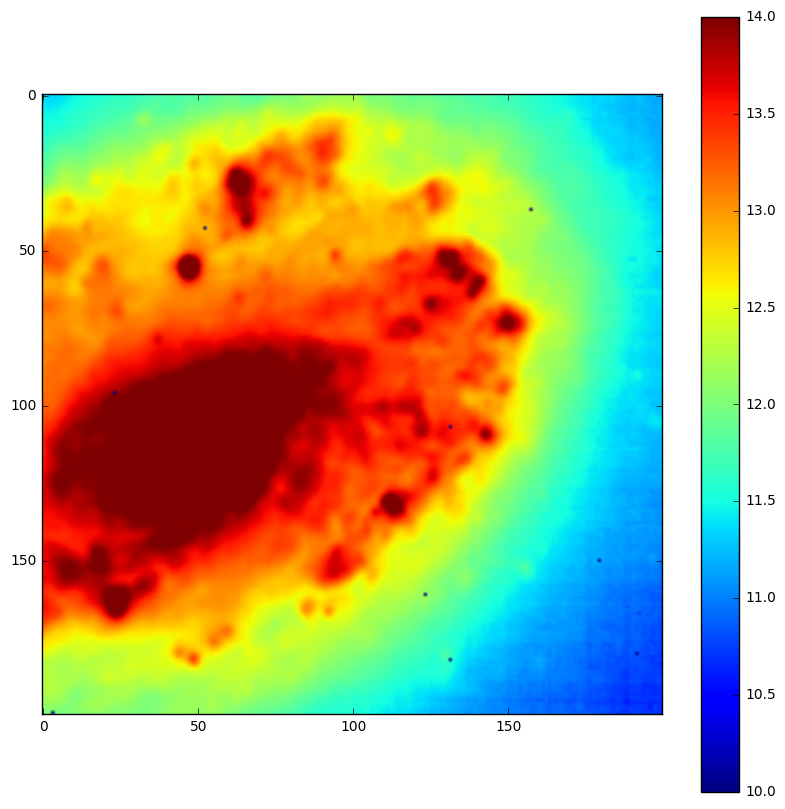

In [162]:
%matplotlib inline
image2D = np.sum(image, axis=0)
image2D[np.invert(np.isfinite(image2D))] = 0
image2D = np.arcsinh(image2D)
fig, ax = plt.subplots(figsize = (10, 10))
color = ax.imshow(image2D, clim = (10, 14));
fig.colorbar(color);
plt.show()
%matplotlib qt4

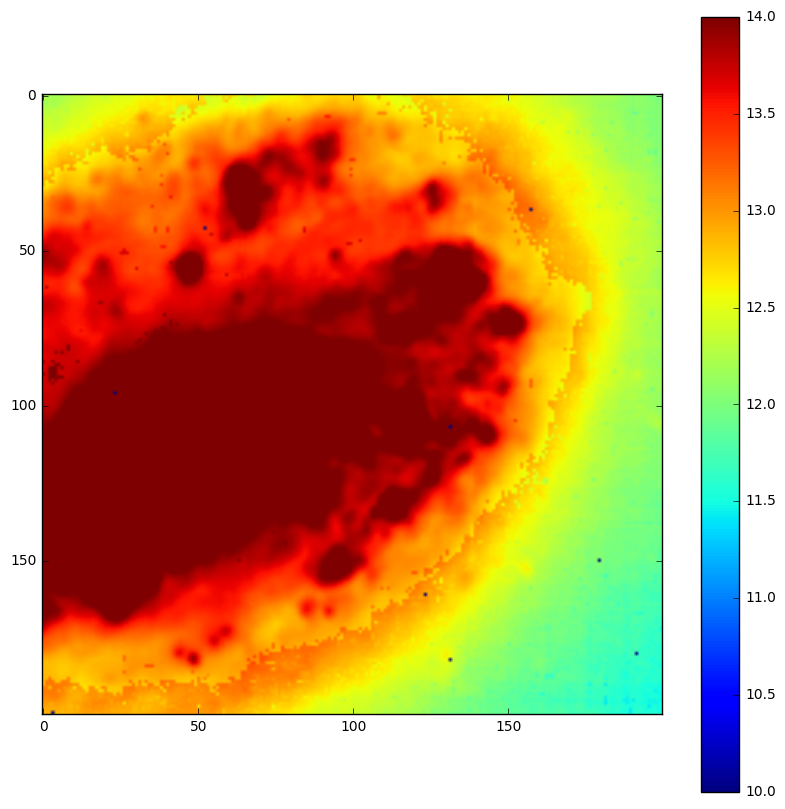

In [161]:
%matplotlib inline
image2D = np.sum(matrix, axis=0)
image2D[np.invert(np.isfinite(image2D))] = 0
image2D = np.arcsinh(image2D)
fig, ax = plt.subplots(figsize = (10, 10))
color = ax.imshow(image2D, clim = (10, 14));
fig.colorbar(color);
plt.show()
%matplotlib qt4

In [226]:
H_o = 4102.89
H_y = 4341.68
H_b = 4862.68
O_3 = 4960.295
O_32 = 5008.240


N_2 = 6549.86 # 6535
H_alpha = H_alpha #6556
N_22 = 6585.27 # 6570
S_2 = 6718.29 # 6700
S_22 = 6732.67 # 6720

titles = {
6542 :"6549.8 = N_2",
6554 :"6562.8 = H_alpha",
6577 :"6585.2 = N_2_2",
6713 :"6718.2 = S_2",
6724 :"6732.6 = S_2_2",
}


In [227]:
matrix=new_image # Read the numpy matrix with images in the rows

_m = 6450#_minimum
_mm = 8000

fig, ax = plt.subplots(figsize = (10, 10))
color = ax.imshow(image2D, clim = (10, 270), cmap=plt.cm.summer);
fig.colorbar(color);

title = "6562.8 = H_alpha"
wait = 0.01
_k = 0 

for i, row in enumerate(matrix[_m-_minimum:_mm-_minimum,:,:]):
    
    if _m+i in titles:
        title = titles[_m+i]
        wait = .3
        _k = _m+i
    elif _m+i > _k+10:
        wait = 0.01
        
    plt.title("{} / {}".format(_m+i,title),fontsize=30)
    
    color.set_array(row)
    plt.pause(wait)
    plt.show(block = False)
    

/usr/local/lib/python3.5/dist-packages/matplotlib/backend_bases.py:2437: MatplotlibDeprecationWarning: Using default event loop until function specific to this GUI is implemented
  warnings.warn(str, mplDeprecation)


KeyboardInterrupt: 